In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

**Introduction**

We will be analyzing players and team performance in the English Premier League (EPL) using data scraped from understat.com as well as some data from fantasy.premierleague.com. From understat we will mostly be looking at their 'expected goals/assists' (xG and xA) data while fanatasy.premierleague will provide fixture information.

Expected Metric:

    Expected Gaols (xG) - measures the likelyhood of a particular shot made by a player resulting in a goal. An xG of 0.9 means that 90% of the time a player would be expected to score that shot. Every shot a player takes in a game is assigned and xG value. So if Player A took five shots in a game that had an xG of 0.5 then their xG for that game is 2.5. In other words, Player A was expected to score 2.5 goals that game when in reality they may have only more or less.
    
    Expected Assists (xA) - likelyhood that a pass made to another player results in a goal
    
   There is a lot more information on the expected metric here https://www.americansocceranalysis.com/explanation/

In [2]:
def get_team_soup(team):
    # grabs the url for a particular team and returns a Beautifulsoup object containing player data for a that team
    xg_url = 'https://understat.com/team/' + team
    
    options = webdriver.ChromeOptions()
    options.add_argument('headless')
    driver = webdriver.Chrome(options=options)
    driver.get(xg_url)
    team_soup = BeautifulSoup(driver.page_source, 'lxml')
    
    return team_soup

In [3]:
def get_EPL_soup():
    # grabs the url for the EPL and returns a Beautifulsoup object for each team(not player data) in the league
    xg_url = 'https://understat.com/league/EPL'
    
    options = webdriver.ChromeOptions()
    options.add_argument('headless')
    driver = webdriver.Chrome(options=options)
    driver.get(xg_url)
    EPL_soup = BeautifulSoup(driver.page_source, 'lxml')
    
    return EPL_soup

In [4]:
def xG_EPL_Scraper(soup):
    # Returns a dataframe containing team xg data for all teams in the EPL
    
    headers = soup.find('div', attrs={'class':'chemp margin-top jTable'}).find('table').find_all('th',attrs={'class':'sort'})
    headers_list = []
    
    for header in headers:
        headers_list.append(header.get_text(strip=True))
    
    body = soup.find('div', attrs={'class':'chemp margin-top jTable'}).table.tbody
    all_rows_list = []

    for tr in body.find_all('tr'):
        row = tr.find_all('td')
        current_row = []
        for item in row:
            current_row.append(item.get_text(strip=True))
        all_rows_list.append(current_row)

    xg_df = pd.DataFrame(all_rows_list, columns = headers_list)    
    
    return xg_df

In [29]:
def xG_Team_Scraper(soup):
    # Returns a dataframe containing a particlar team's players' xg data
   
    headers = soup.find('div', attrs={'class':'players margin-top jTable'}).find('table').find_all('th',attrs={'class':'sort'})
    header_list = []

    for header in headers:
        header_list.append(header.get_text(strip = True))

    header_list = ['№', 'Player','Pos','Apps', 'Min', 'G', 'A', 'Sh90', 'KP90', 'xG', 'xA', 'xG90', 'xA90']
    
    body = soup.find('div', attrs={'class':'players margin-top jTable'}).find('table').find('tbody')
    all_rows_list = []

    for tr in body.find_all('tr'):
        row = tr.find_all('td')
        current_row = []
        for item in row:
            current_row.append(item.get_text(strip = True))
        all_rows_list.append(current_row)
    
    team_xg = pd.DataFrame(all_rows_list, columns = header_list)
    
   
    return team_xg

In [26]:
def get_all_player_xg(teams):
    #Returns a dataframe of all player stats in EPL
    
    df = pd.DataFrame()
    
    for team in teams:
        team_soup = get_team_soup(team)
        team_df = xG_Team_Scraper(team_soup)

        team_df.insert(1,column = 'Team', value = team)

        df = pd.concat([df, team_df], ignore_index=True)

        # Use timer to avoid requesting data from understat too frequently
        time.sleep(10)
            
        print(f"{team}: Done")
    
    return df

In [7]:
def get_json(file_path):
    # Get json file from fanatsy.premierleague
    r = requests.get('https://fantasy.premierleague.com/drf/bootstrap')
    jsonResponse = r.json()
    with open(file_path, 'w') as outfile:
        json.dump(jsonResponse, outfile)

In [8]:
def get_fixtures_EPL(epl_players):
    # Updates the EPL player dataframe with upcoming fixture information
    
    players = epl_players
    
    get_json(r"C:\Users\TinyPoots\OneDrive\Python\FPL\fpl.json")
    
    with open(r"C:\Users\TinyPoots\OneDrive\Python\FPL\fpl.json") as json_data:
        d = json.load(json_data)
    
    # normalize json in to flat table
    df = json_normalize(d['teams'])
    id_df = df[['id','name']]
    
    # Several of the names on from Fantasy.premierleague are different from the name used on Understat
    id_df['name'].replace({'Wolves':'Wolverhampton Wanderers','Newcastle':'Newcastle United','Man City':'Manchester City', 
                                   'Man Utd':'Manchester United', 'Spurs':'Tottenham'}, inplace = True)
    
    team_id = dict(zip(list(id_df['id']),list(id_df['name'])))
    
    df = json_normalize(d['next_event_fixtures'])
    fixtures_df = df[['event','team_h','team_a']]
    
    # Change team names to the ones used in Understat data
    fixtures_df['team_a'] = fixtures_df['team_a'].map(team_id)
    fixtures_df['team_h'] = fixtures_df['team_h'].map(team_id)
    
    home_team = list(fixtures_df['team_h'])
    away_team = list(fixtures_df['team_a'])
    fixture_dict = dict(zip(home_team, away_team))
    fixture_dict.update(dict(zip(away_team, home_team)))
    
    # Add upcoming fixture data to the players dataframe
    players['Next Opp'] = players['Team'].map(fixture_dict)
    players['Home'] = players['Next Opp'].apply(lambda x: True if (x in away_team) else False)
    
    return players

In [3]:
def remove_plus_minus(num):
    # Removes the '+ -' from a string and converts to a float
    # e.g. 3+1 -> 3
    if len(num.split('-')) == 2:
        return num.split('-')[0]
    elif len(num.split('+')) == 2:
        return num.split('+')[0]
    else:
        return float(num)

**Use the xG_EPL_Scraper and the get_EPL_soup functions to obtain team data**

In [4]:
epl_df = pd.read_csv('xg_EPL.csv', index_col = 0)

In [5]:
epl_df.head(10)

,№,Team,M,W,D,L,G,GA,PTS,xG,xGA,xPTS
0,1,Manchester City,30,24,2,4,79,21,74,76.75-2.25,21.68+0.68,71.82-2.18
1,2,Liverpool,30,22,7,1,68,17,73,63.12-4.88,22.13+5.13,66.61-6.39
2,3,Tottenham,30,20,1,9,57,32,61,50.19-6.81,39.01+7.01,49.50-11.50
3,4,Arsenal,30,18,6,6,63,39,60,52.96-10.04,42.57+3.57,48.33-11.67
4,5,Manchester United,30,17,7,6,58,40,58,56.23-1.77,41.74+1.74,49.76-8.24
5,6,Chelsea,29,17,6,6,50,31,57,47.27-2.73,29.67-1.33,53.71-3.29
6,7,Wolverhampton Wanderers,30,12,8,10,38,36,44,41.36+3.36,32.11-3.89,47.68+3.68
7,8,Watford,30,12,7,11,42,44,43,41.07-0.93,45.31+1.31,40.04-2.96
8,9,West Ham,30,11,6,13,37,43,39,36.53-0.47,51.78+8.78,33.66-5.34
9,10,Leicester,30,11,5,14,38,42,38,39.75+1.75,35.79-6.21,44.27+6.27


In [6]:
epl_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20 entries, 0 to 19
Data columns (total 12 columns):
№       20 non-null int64
Team    20 non-null object
M       20 non-null int64
W       20 non-null int64
D       20 non-null int64
L       20 non-null int64
G       20 non-null int64
GA      20 non-null int64
PTS     20 non-null int64
xG      20 non-null object
xGA     20 non-null object
xPTS    20 non-null object
dtypes: int64(8), object(4)
memory usage: 2.0+ KB


In [7]:
# Clean epl_df

epl_df.drop(['xPTS', 'PTS'], axis = 1, inplace = True)

epl_df.rename(columns = {'№':'Rank'}, inplace = True)

epl_df['xG'] = epl_df['xG'].apply(remove_plus_minus)
epl_df['xGA'] = epl_df['xGA'].apply(remove_plus_minus)

# Convert all strings to numeric values where possible 
epl_df = epl_df.apply(pd.to_numeric, errors='ignore')


In [8]:
# Create Goal difference and Expected Goal Difference columns

epl_df['GD'] = epl_df['G'] - epl_df['GA']
epl_df['xGD'] = epl_df['xG'] - epl_df['xGA']

cols = list(epl_df.drop(['Rank', 'Team', 'M', 'W', 'D', 'L'], axis = 1))

# Create per game data

for c in cols:
    epl_df[f"{c}_pg"] = (epl_df[c] / epl_df['M']).round(2)


In [9]:
epl_df.head(2)

,Rank,Team,M,W,D,L,G,GA,xG,xGA,GD,xGD,G_pg,GA_pg,xG_pg,xGA_pg,GD_pg,xGD_pg
0,1,Manchester City,30,24,2,4,79,21,76.75,21.68,58,55.07,2.63,0.70,2.56,0.72,1.93,1.84
1,2,Liverpool,30,22,7,1,68,17,63.12,22.13,51,40.99,2.27,0.57,2.10,0.74,1.70,1.37


**Done with the league data for the moment. Now we'll focus on getting player data**

In [10]:
player_df = pd.read_csv('xg_Players.csv', index_col = 0)

In [11]:
player_df.head(2)

,№,Team,Player,Pos,Apps,Min,G,A,Sh90,KP90,xG,xA,xG90,xA90,Next Opp,Home
0,1,Manchester City,Sergio Agüero,F,26,1960,18,6,4.36,1.15,17.52-0.48,3.78-2.22,0.80,0.17,NaN,False
1,2,Manchester City,Raheem Sterling,F M,27,2159,15,9,2.38,2.29,12.54-2.46,9.91+0.91,0.52,0.41,NaN,False


In [12]:
player_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 496 entries, 0 to 495
Data columns (total 16 columns):
№           496 non-null int64
Team        496 non-null object
Player      496 non-null object
Pos         496 non-null object
Apps        496 non-null int64
Min         496 non-null int64
G           496 non-null int64
A           496 non-null int64
Sh90        496 non-null float64
KP90        496 non-null float64
xG          496 non-null object
xA          496 non-null object
xG90        496 non-null float64
xA90        496 non-null float64
Next Opp    248 non-null object
Home        496 non-null bool
dtypes: bool(1), float64(4), int64(5), object(6)
memory usage: 62.5+ KB


In [13]:
# Clean player_df

player_df.drop('№', axis=1, inplace = True)

player_df['xA'] = player_df['xA'].apply(remove_plus_minus)
player_df['xG'] = player_df['xG'].apply(remove_plus_minus)

# Convert all strings to numeric values where possible 
player_df = player_df.apply(pd.to_numeric, errors='ignore')

# Assists and goals per game
player_df['AP90'] = (player_df['A'] / (player_df['Min'] / 90)).apply(lambda x: round(x,2))
player_df['GP90'] = (player_df['G'] / (player_df['Min'] / 90)).apply(lambda x: round(x,2))

# Total Goal Contribution (G+A)
player_df['G+A'] = player_df['G'] + player_df['A']

# Some players have two postions listed, we dropped the second one
player_df['Pos'] = player_df['Pos'].apply(lambda x: x.split()[0])

In [14]:
player_df.head(2)

,Team,Player,Pos,Apps,Min,G,A,Sh90,KP90,xG,xA,xG90,xA90,Next Opp,Home,AP90,GP90,G+A
0,Manchester City,Sergio Agüero,F,26,1960,18,6,4.36,1.15,17.52,3.78,0.80,0.17,NaN,False,0.28,0.83,24
1,Manchester City,Raheem Sterling,F,27,2159,15,9,2.38,2.29,12.54,9.91,0.52,0.41,NaN,False,0.38,0.63,24


In [37]:
# Adjust the xG goals of the players based on their xG90, the opponents xGA_pg, and whether they're playing home or away

player_df['Opp xGA_pg'] = player_df['Next Opp'].apply(lambda x: float(epl_df[epl_df['Team'] == x]['xGA_pg']))

xG_avg = epl_df['xG_pg'].mean()

# More likely to score at home so multiply by 1.1, away * 0.87
player_df['Adjusted xG for Next Match'] = np.where(player_df['Home'] == True, 
                                        (((player_df['xG90'] * player_df['Opp xGA_pg']) / xG_avg)*1.1).round(2),
                                        (((player_df['xG90'] * player_df['Opp xGA_pg']) / xG_avg)*0.87).round(2))

TypeError: cannot convert the series to <class 'float'>

In [90]:
player_df.head(2)

,Team,Player,Pos,Apps,Min,G,A,Sh90,KP90,xG,xA,xG90,xA90,AP90,GP90,G+A,Next Opp,Home,Opp xGA_pg,Adjusted xG for Next Match
0,Liverpool,Mohamed Salah,F,24,2035,16,7,3.36,2.17,15.72,8.22,0.70,0.36,0.31,0.71,23,Bournemouth,True,1.55,0.85
1,Liverpool,Sadio Mané,F,22,1857,10,1,2.57,1.31,8.14,3.00,0.39,0.15,0.05,0.48,11,Bournemouth,True,1.55,0.48


**With the data cleaned we can do some visualizations of the data**

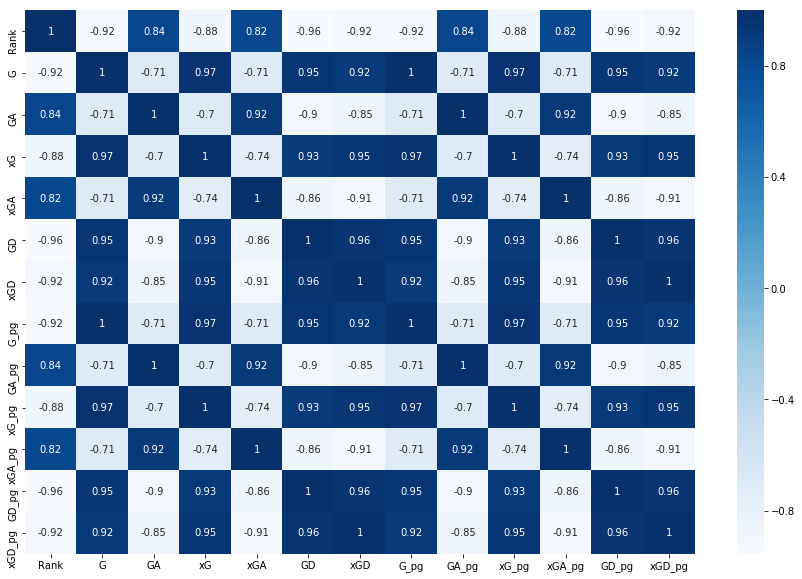

In [51]:
# Heatmap
fig = plt.figure(figsize=(15,10))
sns.heatmap(epl_df.drop(['Team', 'M', 'W', 'D', 'L'], axis =1).corr(), cmap = 'Blues', annot = True)

**The most important information we can draw from this table is the correlation bewtween Rank and all the other features. Rank clearly has a strong correlation (>0.8) with all the other features. This is to be expected since a team that scores more goals and concedes less goals will most likely win most of their games and achieve a higher Rank.**

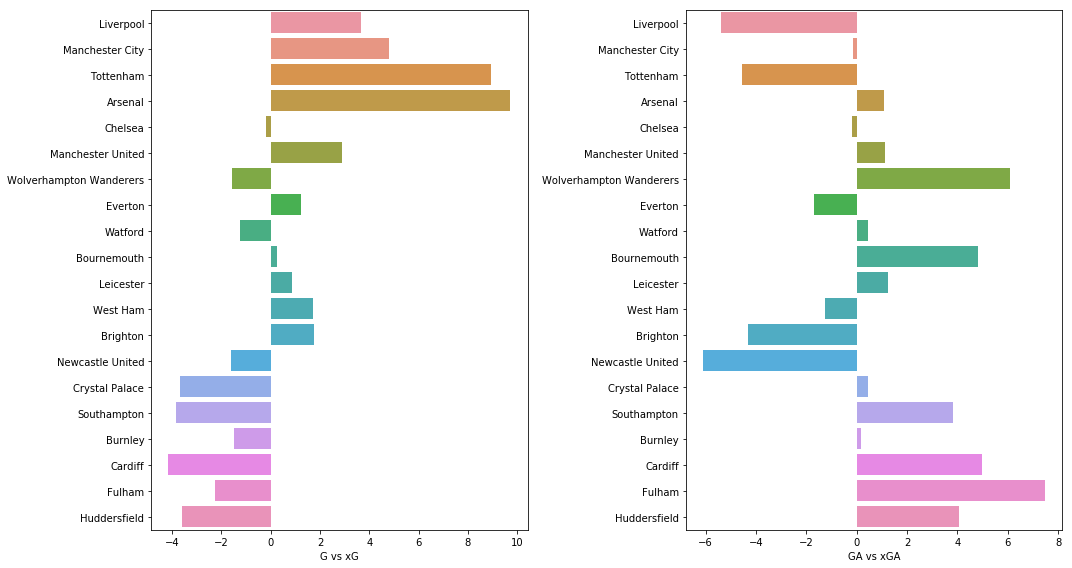

In [49]:
diff_df = pd.DataFrame(epl_df[['Rank', 'Team']])
diff_df['G vs xG'] = epl_df['G'] - epl_df['xG']
diff_df['GA vs xGA']= epl_df['GA'] - epl_df['xGA']


# Bar plot of difference between expected and actual data
fig, axes = plt.subplots(ncols = 2, figsize=(15,8))

sns.barplot(data = diff_df, y = 'Team', x = 'G vs xG', ax=axes[0])
sns.barplot(data = diff_df, y = 'Team', x = 'GA vs xGA', ax=axes[1])

axes[0].set_ylabel('')
axes[1].set_ylabel('')

plt.tight_layout()

**In general, it would seem that top teams overperform in terms of goals while the bottom teams underperform. This is most likely down to the fact that top teams have more effecient goals scorers compared to the bottom teams. They're doesnt seem to be a clear trend in GA other than the bottom teams conceding more than expected which can be do to lack of quality players (which is why they're probably at the bottom of the table).**

**Who on Arsenal is overperforming?**

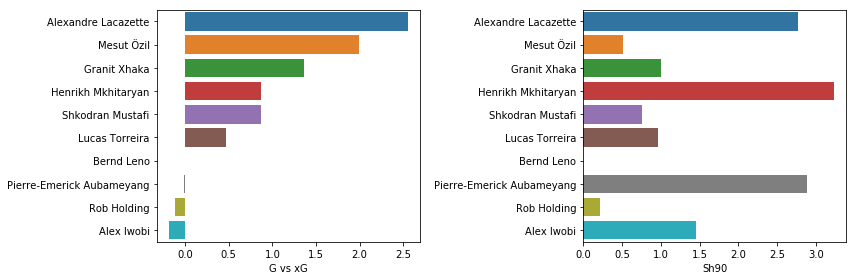

In [166]:
# Arsenal
ars_df = pd.DataFrame(player_df[player_df['Team'] ==  'Arsenal'])
ars_df['G vs xG'] = ars_df['G'] - ars_df['xG']

# Barplot of G - xG
fig, axes = plt.subplots(figsize = (12,4), ncols = 2)

# Only using players with over 700 minutes since a small amount of minutes can skew the xG data
sns.barplot(x = 'G vs xG', y = 'Player',data=ars_df[ars_df['Min'] > 700].sort_values('G vs xG', ascending = False).head(10), ax = axes[0])
sns.barplot(x = 'Sh90', y = 'Player',data=ars_df[ars_df['Min'] > 700].sort_values('G vs xG', ascending = False).head(10), ax=axes[1])

axes[0].set_ylabel('')
axes[1].set_ylabel('')

plt.tight_layout()

**Now we can see who is outscoring their 'xG'. Ozil and Xhaka take very few shots which will lead to a lower xG which explains why they outscored their xG. Lacazette however takes a lot of shots per game and is still outscoring his xG by 2.55 implying Lacazette is a very good goal scorer (or very lucky)**

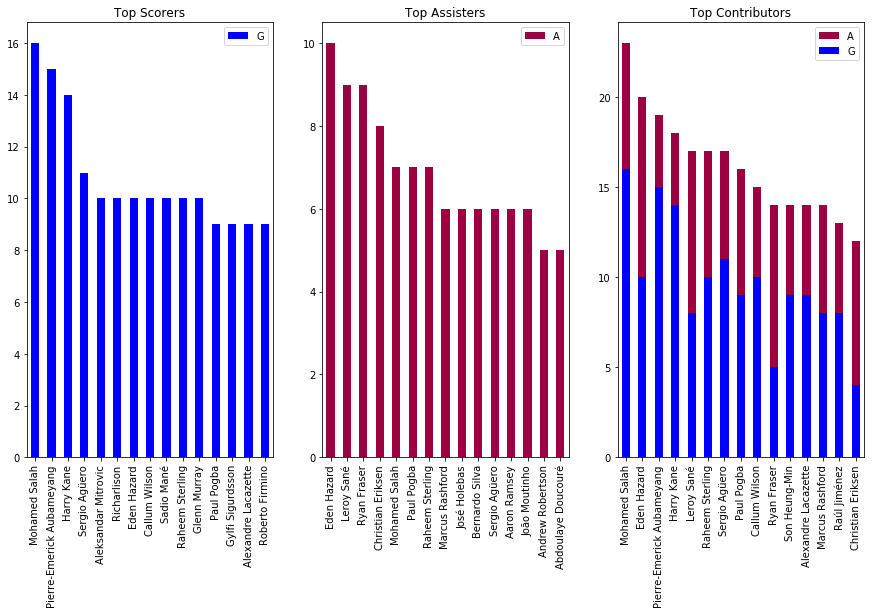

In [117]:
top_scorers   = player_df.sort_values('G',ascending=False).head(15)
top_assisters = player_df.sort_values('A',ascending=False).head(15)
top_contributers = player_df.sort_values('G+A',ascending=False).head(15)

# Barplot of top (15) scorers and assisters and total goal contribution (G+A)
fig, axes = plt.subplots(figsize = (15,8), ncols = 3)
top_scorers.plot(kind = 'bar', x = 'Player', y = 'G', ax = axes[0], colormap = 'winter')
top_assisters.plot(kind = 'bar', x = 'Player', y = 'A', ax = axes[1],  colormap = 'Spectral')
top_contributers.plot(kind = 'bar', x = 'Player', y = 'G+A', ax = axes[2], colormap = 'Spectral')
top_contributers.plot(kind = 'bar', x = 'Player', y = 'G', ax = axes[2], colormap = 'winter')

axes[0].set_xlabel('')
axes[0].set_title('Top Scorers')
axes[1].set_xlabel('')
axes[1].set_title('Top Assisters')
axes[2].set_xlabel('')
axes[2].set_title('Top Contributors')
axes[2].legend(['A', 'G'])

plt.show()

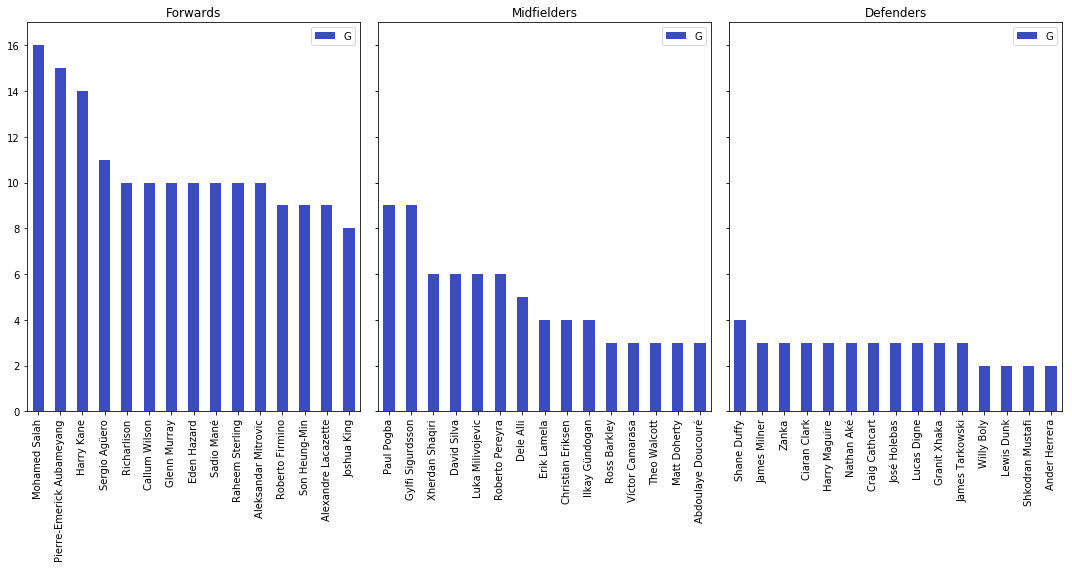

In [164]:
top_fow = player_df[player_df['Pos'] == 'F'].sort_values('G', ascending = False).head(15)
top_mids = player_df[player_df['Pos'] == 'M'].sort_values('G', ascending = False).head(15)
top_def = player_df[player_df['Pos'] == 'D'].sort_values('G', ascending = False).head(15)

# Barplot of top scorers in each position (pos). Forward (F), Midfielder (M), Defender(D)
fig, axes = plt.subplots(figsize = (15,8), ncols = 3)

top_fow.plot(kind = 'bar', x = 'Player', y='G', ax = axes[0], colormap = 'coolwarm',sharey = True, ylim = [0,17])
axes[0].set_title('Forwards')

top_mids.plot(kind = 'bar', x = 'Player', y='G', ax = axes[1], colormap = 'coolwarm',sharey = True, ylim = [0,17])
axes[1].set_title('Midfielders')

top_def.plot(kind = 'bar', x = 'Player', y='G', ax = axes[2], colormap = 'coolwarm',sharey = True, ylim = [0,17])
axes[2].set_title('Defenders')

axes[0].set_xlabel('')
axes[1].set_xlabel('')
axes[2].set_xlabel('')

plt.tight_layout()

**Lets look closer at Midfielders in the EPL**

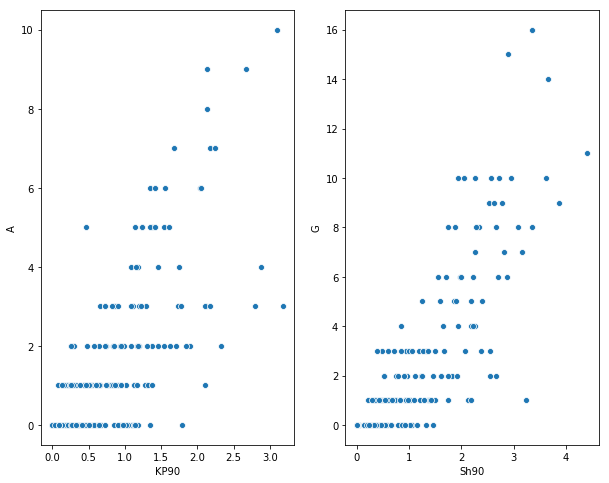

In [187]:
# Looks at Midfielders that have actaully played a significant amount
mids = player_df[player_df['Min'] > 1200]

# Boxplot
fig, axes = plt.subplots(figsize = (10,8), ncols = 2)

sns.scatterplot(x = 'KP90', y = 'A', data = mids, ax=axes[0])
sns.scatterplot(x = 'Sh90', y = 'G', data = mids, ax=axes[1])

**As one would expect, the more shots per 90 generally leads to more goals and the same with Key Passes and Assists**

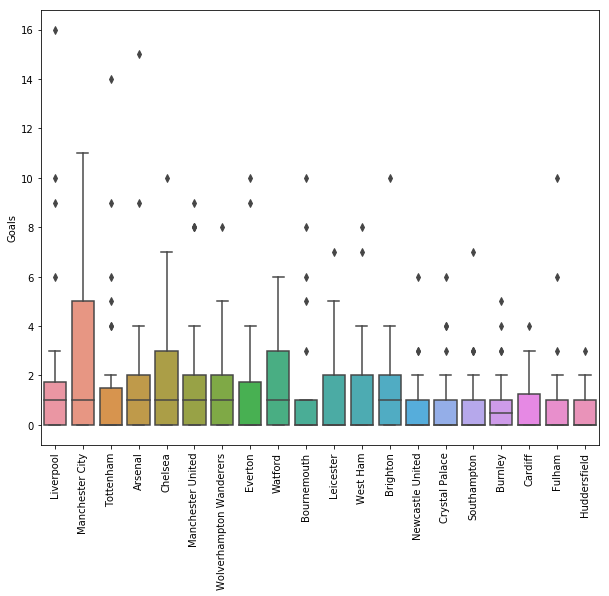

In [190]:
# Boxplot of teams vs their goals
fig, axes = plt.subplots(figsize = (10,8))
sns.boxplot(x = 'Team', y = 'G', data = player_df)
plt.xticks(rotation = 90)
axes.set_xlabel('')
axes.set_ylabel('Goals')
plt.show()

**One the that sticks out is how unreliant Manchester City are any one goal scorer. Several players on their team have a multiple goals**

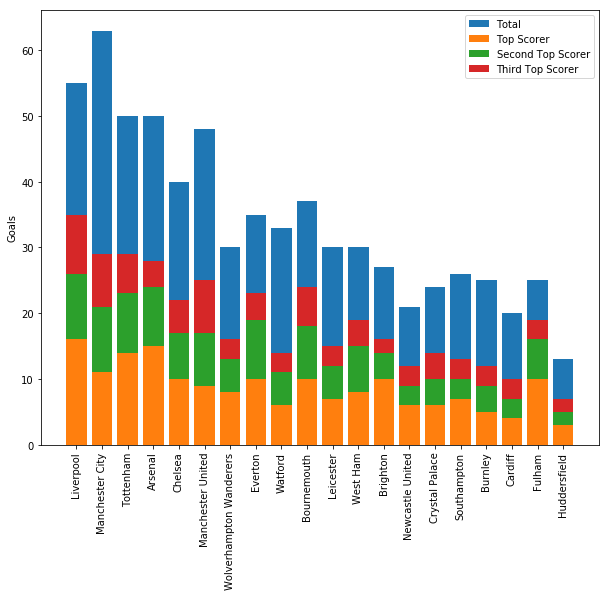

In [141]:
# Make a new dataframe that contains total goals scored by each team and the top (3) scorers of each team
total_goals = []

for team in team_names:
    total_goals.append(int(epl_df[epl_df['Team'] == team]['G']))

total_team_goals = pd.DataFrame({'Team':team_names, 'Goals': total_goals})


# Get top 3 goal scorers of each team and how many goals they scored
first_scorer = []
second_scorer = []
third_scorer = []
first_goals = []
second_goals = []
third_goals = []


for team in team_names:
    names= list(player_df[player_df['Team'] == team][['Player', 'G']].sort_values('G', ascending = False).iloc[0:3]['Player'])
    goals= list(player_df[player_df['Team'] == team][['Player', 'G']].sort_values('G', ascending = False).iloc[0:3]['G']) 
    
    first_scorer.append(names[0])
    second_scorer.append(names[1])
    third_scorer.append(names[2])
    
    first_goals.append(goals[0])
    second_goals.append(goals[1])
    third_goals.append(goals[2])
    

total_team_goals['First'] = first_scorer
total_team_goals['Second'] = second_scorer
total_team_goals['Third'] = third_scorer

total_team_goals['First Goals'] = first_goals
total_team_goals['Second Goals'] = second_goals
total_team_goals['Third Goals'] = third_goals


# Stacked Barplot of the total goals scored by the three top scorers for each team
# This will show how reliant each team is on their top goal scorers for goals
fig = plt.subplots(figsize=(10,8))

p1 = plt.bar(total_team_goals['Team'], total_team_goals['Goals'])
p2 = plt.bar(total_team_goals['Team'], total_team_goals['First Goals'] )
p3 = plt.bar(total_team_goals['Team'], total_team_goals['Second Goals'] , bottom =total_team_goals['First Goals'] )
p4 = plt.bar(total_team_goals['Team'], total_team_goals['Third Goals'] , 
             bottom=[i+j for i,j in zip(total_team_goals['First Goals'] , total_team_goals['Second Goals'] )])


plt.xticks(rotation = 90)
plt.legend(('Total','Top Scorer', 'Second Top Scorer', 'Third Top Scorer'), loc ='best')
plt.ylabel('Goals')

plt.show()

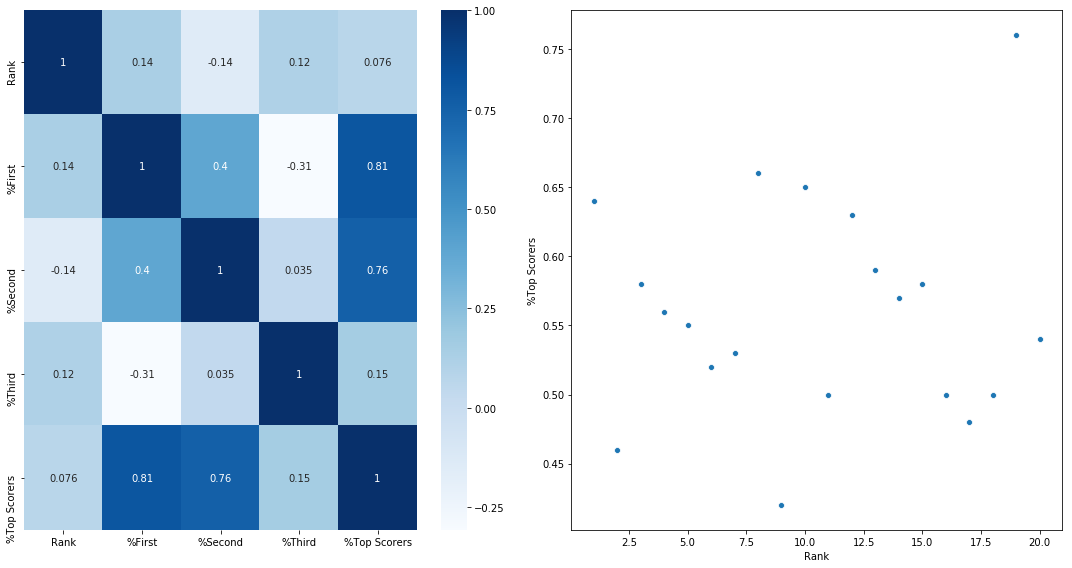

In [191]:
# Check to see if there is correlation between the percentage of goals scored by the top 3 of each team and the team rank
total_team_goals['%First'] = (total_team_goals['First Goals'] / total_team_goals['Goals']).round(2)
total_team_goals['%Second'] = (total_team_goals['Second Goals'] / total_team_goals['Goals']).round(2)
total_team_goals['%Third'] = (total_team_goals['Third Goals'] / total_team_goals['Goals']).round(2)
total_team_goals['%Top Scorers'] = ((total_team_goals['Third Goals'] + total_team_goals['First Goals'] + total_team_goals['Second Goals'])
                                    / total_team_goals['Goals']).round(2)
total_team_goals['Rank'] = range(1,21)

# Scatter plot of team position vs %Top Scorers and heatmap
fig, axes = plt.subplots(ncols = 2, figsize = (15,8))


sns.heatmap(total_team_goals[['Rank', '%First', '%Second', '%Third', '%Top Scorers']].corr(), cmap = "Blues", annot = True, ax=axes[0])
sns.scatterplot(x = 'Rank', y= '%Top Scorers', data = total_team_goals, ax = axes[1])

plt.tight_layout()


**It can be seen that there is no clear relationship bewteen rank and % of goals scored by a team's top scorers**

In [153]:
total_team_goals.sort_values('%Top Scorers', ascending = False).head()

,Team,Goals,First,Second,Third,First Goals,Second Goals,Third Goals,%First,%Second,%Third,%Top Scorers,Rank
18,Fulham,25,Aleksandar Mitrovic,André Schürrle,Aboubakar Kamara,10,6,3,0.40,0.24,0.12,0.76,19
7,Everton,35,Richarlison,Gylfi Sigurdsson,Dominic Calvert-Lewin,10,9,4,0.29,0.26,0.11,0.66,8
9,Bournemouth,37,Callum Wilson,Joshua King,David Brooks,10,8,6,0.27,0.22,0.16,0.65,10
0,Liverpool,55,Mohamed Salah,Sadio Mané,Roberto Firmino,16,10,9,0.29,0.18,0.16,0.64,1
11,West Ham,30,Felipe Anderson,Marko Arnautovic,Chicharito,8,7,4,0.27,0.23,0.13,0.63,12


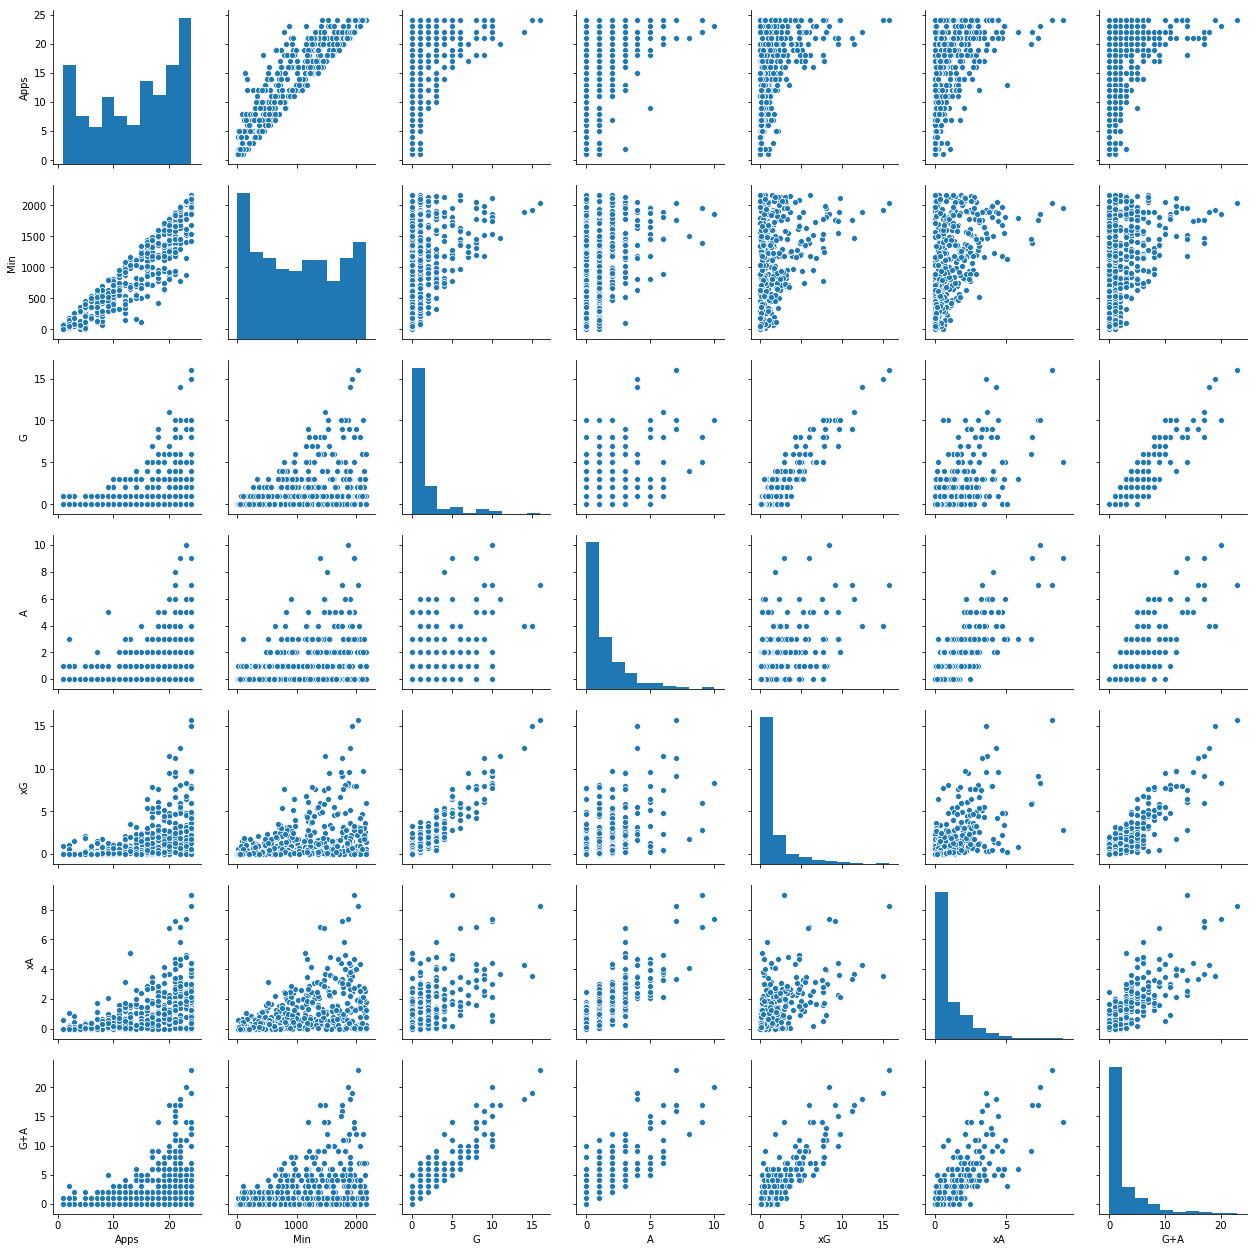

In [154]:
# Pairplot, dropped the per 90 features
sns.pairplot(player_df.drop(['Team', 'Player','Home', 'Next Opp', 'Opp xGA_pg', 'Adjusted xG for Next Match', 'xG90', 
                                 'xA90', 'AP90', 'GP90', 'Sh90','KP90'] , axis = 1))
plt.show()

**Apps vs Mins: asymptote at the maximum number a minutes a player could play given how many appearances they made (e.g. a player with 10 appearances can have up to 900 mins)**

**Apps/Mins vs G/A/xG/xA: there appears to be an exponetial realtionship bewtween the these features. The more time a player has on the field expontial increases the amount of goals/assists they can score**


**The main goal when starting this project was to try to predict who is most likely to score in the coming fixture. So let's finish with that**

In [196]:
player_df[player_df['Min'] > 1200].sort_values('Adjusted xG for Next Match', ascending = False).head(10)[['Player', 'Adjusted xG for Next Match']]

,Player,Adjusted xG for Next Match
0,Mohamed Salah,0.85
345,Danny Ings,0.75
118,Paul Pogba,0.67
70,Pierre-Emerick Aubameyang,0.67
279,Glenn Murray,0.66
121,Romelu Lukaku,0.62
43,Harry Kane,0.56
2,Roberto Firmino,0.56
120,Marcus Rashford,0.56
22,Sergio Agüero,0.54


**Conclusion**

As